In [110]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, confusion_matrix, f1_score
import xgboost as xgb

from utils import SOSEncoder, TargetEncoder, EqualSplit

import warnings
warnings.filterwarnings('ignore')

## Configuration

In [128]:
DIR = 'D:\\PPrograms\\Python\\Kaggle\\Predicting Loan Pay\\'
TARGET = 'loan_paid_back'
SEED = 42
CV = 5

In [129]:
Train = pd.read_csv(os.path.join(DIR, 'data\\train.csv'), index_col='id')
test = pd.read_csv(os.path.join(DIR, 'data\\test.csv'), index_col='id')

In [130]:
nvp = np.sum(Train[TARGET]==0)/np.sum(Train[TARGET]==1)
multi_n = round(1/nvp)
print(f'The ratio of negative sample vs positive sample is {nvp}({multi_n}).')

The ratio of negative sample vs positive sample is 0.25184723094496453(4).


In [131]:
NUM = [col for col in test.columns if Train[col].dtypes in ('float64', 'int64')]
CAT = [col for col in test.columns if Train[col].dtypes in ('object',)]
COL = NUM + CAT
print(f'There are {test.shape[1]} cols, in which {len(NUM)} are numerical and {len(CAT)} are categorical.')

There are 11 cols, in which 5 are numerical and 6 are categorical.


In [132]:
Train, valid = train_test_split(Train, test_size=0.2, random_state=SEED, stratify=Train[TARGET])

## Data Equal Split

In [133]:
esplit = EqualSplit(random_state=SEED)
train, _ = esplit.fit_resample(Train, Train[TARGET])
print(f'Data is split into {esplit.n_split_} folds, each fold has {esplit.majority_} major samples and {esplit.minority_} minor samples.')

Data is split into 4 folds, each fold has 94898 major samples and 95600 minor samples.


## Feature Engineering
### Frequency

In [134]:
FREQ = []


def generate_frequency_feature(df, *df_other, append=True):
    train = pd.DataFrame(index=df.index)
    other = [pd.DataFrame(index=_.index) for _ in df_other]

    for col in COL:
        # --- Ratio Features ---
        # count the ratio of occurrences of each unique values
        freq= df[col].value_counts()/df.shape[0]
        col_name = f'{col}_freq'
        train[col_name] = df[col].map(freq)
        for i in range(len(other)):
            other[i][col_name] = df_other[i][col].map(freq).fillna(freq.mean())

        if append:
            FREQ.append(col_name)
        # --- Bin Features ---
        # split the numerical col into bins
        if col in NUM:
            for q in [5, 10, 15]:
                train_bins, bins = pd.cut(df[col], bins=q, labels=False, retbins=True, duplicates="drop")
                col_name = f'{col}_bins{q}'
                train[col_name] = train_bins
                for i in range(len(other)):
                    other[i][col_name] = pd.cut(df_other[i][col], bins=bins, labels=False, duplicates="drop", include_lowest=True)

                if append:
                    FREQ.append(col_name)
    # --- Weighted Bins Features ---
    # split the numerical col into bins while label there weight
    sos = SOSEncoder(20)
    res = sos.fit_transform(df[NUM])
    train = train.join(res)
    for i in range(len(other)):
        res = sos.transform(df_other[i][NUM])
        other[i] = other[i].join(res)

    if append:
        FREQ.extend(sos.res_columns)

    # concatenate all features at once
    df = pd.concat([df, train], axis=1)
    for i in range(len(other)):
        other[i] = pd.concat([df_other[i], other[i]], axis=1)
    return df, *other


Train, test, valid = generate_frequency_feature(Train, *[test, valid])
for i, data in enumerate(train):
    train[i], = generate_frequency_feature(data, append=False)
print(f'{len(FREQ)} Frequency features created.')

136 Frequency features created.


### Subgrade

In [135]:
SUBGRADE = []

def generate_subgrade_feature(df, *df_other, append=True):
    grade_map = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4,
        'F': 5,
    }

    df['ordered_grade'] = df['grade_subgrade'].str[0].map(grade_map)
    df['subgrade'] = df['grade_subgrade'].str[1:].astype(int)
    for data in df_other:
        data['ordered_grade'] = data['grade_subgrade'].str[0].map(grade_map)
        data['subgrade'] = data['grade_subgrade'].str[1:].astype(int)
    if append:
        SUBGRADE.append('ordered_grade')
        SUBGRADE.append('subgrade')

    return df, *df_other

Train, test, valid = generate_subgrade_feature(Train, *[test, valid])
for i, data in enumerate(train):
    train[i], = generate_subgrade_feature(data, append=False)
print(f'{len(SUBGRADE)} Subgrade features created.')

2 Subgrade features created.


### OrdCategory

In [136]:
ORDCATE = []
def generate_ordcategory_feature(df, *df_other, append=True):
    edu_map = {
        "Other": 0,
        "High School": 1,
        "Bachelor's": 2,
        "Master's": 3,
        "PhD": 4,
    }
    emp_map = {
        'Unemployed': 0,
        'Student': 1,
        'Self-employed': 2,
        'Employed': 3,
        'Retired': 4,
    }
    for data in [df, *df_other]:
        data['ordered_edu_level'] = data['education_level'].map(edu_map)
        data['ordered_employment_status'] = data['employment_status'].map(emp_map)
    if append:
        ORDCATE.append('ordered_edu_level')
        ORDCATE.append('ordered_employment_status')

    return df, *df_other

Train, test, valid = generate_ordcategory_feature(Train, test, valid)
for i, data in enumerate(train):
    train[i], = generate_ordcategory_feature(data, append=False)
print(f'{len(ORDCATE)} Ordcategory features created.')

2 Ordcategory features created.


### Round

In [143]:
ROUND = []

def generate_round_feature(df, *df_other, append=True):
    rounding_levels = {
        '1r': 0,
        '10r': -1,
        '100r': -2
    }
    for col in ['annual_income', 'loan_amount']:
        for suffix, level in rounding_levels.items():
            col_name = f'{col}_{suffix}'
            for data in [df, *df_other]:
                data[col_name] = data[col].round(level).astype(int)

            if append:
                ROUND.append(col_name)
    return df, *df_other

Train, test, valid = generate_round_feature(Train, test, valid)
for i, data in enumerate(train):
    train[i], = generate_round_feature(data, append=False)
print(f'{len(ROUND)} Round features created.')

6 Round features created.


### Target

In [137]:
TAR = []

def generate_target_feature(df, *df_other, append=True):
    tar = TargetEncoder(cols_to_encode=COL, aggs=['mean'], drop_original=True)
    other = list(df_other)

    df_tar = tar.fit_transform(df[COL], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(tar.transform(other[i][COL]))
    if append:
        TAR.extend(df_tar.columns)

    return df, *other

Train, test, valid = generate_target_feature(Train, test, valid)
for i, data in enumerate(train):
    train[i], = generate_target_feature(data, append=False)
print(f'{len(TAR)} Target features created.')

11 Target features created.


In [138]:
for col in CAT:
    Train[col] = Train[col].astype('category')
    test[col] = test[col].astype('category')
    valid[col] = valid[col].astype('category')
    for i, data in enumerate(train):
        train[i][col] = train[i][col].astype('category')

In [144]:
FEATURES = CAT + NUM + TAR + ROUND + SUBGRADE + FREQ + ORDCATE
print(len(FEATURES), 'Features.')

168 Features.


## Feature Select

In [57]:
base_feas_select = []

In [59]:
def multi_dataset_xgg_feature_test(X_set, y_set, X_cols=None ,cv=5, seed=42, **kwargs):
    res = {
        'auc': [],
        'acc': [],
        'rmse': [],
    }

    # Judge the model type(classification or regression)
    cls_model = True if 'eval_metric' not in kwargs or kwargs['eval_metric']=='auc' else False

    for i, X in enumerate(X_set):
        if type(y_set) is str:
            y = X[y_set]
        else:
            y = y_set[i]
        if X_cols is not None:
            X = X[X_cols]
        print(f"\n{'#'*25}")
        print(f"### BATCH : {i+1} ###")
        print(f"{'#'*25}\n")

        ret = xgg_feature_test(X, y, cv=cv, seed=seed, **kwargs)

        print(f'\n{"+"*25}')
        if cls_model:
            print(f"BATCH{i+1} MEAN AUC: {ret[0]:.5f}, ACC: {ret[1]:.5f}")
            res['auc'].append(ret[0])
            res['acc'].append(ret[1])
        else:
            print(f"BATCH{i+1} MEAN RMSE: {ret[0]:.5f}")
            res['rmse'].append(ret[0])
        print(f'{"+"*25}\n')

    print(f'\n{"="*50}')
    if cls_model:
        print(f"BATCH MEAN AUC = {np.mean(res['auc']):.5f}, ACC = {np.mean(res['acc']):.5f}")
        ret = (np.mean(res['auc']), np.mean(res['acc']))
    else:
        print(f"BATCH MEAN RMSE = {np.mean(res['rmse']):.5f}")
        ret = (np.mean(res['rmse']),)
    print(f'{"="*50}')

    return ret

In [60]:
def xgg_feature_test(X, y, cv=5, seed=42, **kwargs):
    kf = KFold(n_splits=cv, shuffle=True, random_state=seed)

    params = {
        'booster':'gbtree',
        'eval_metric': 'auc',
        "objective": "binary:logistic",
        "tree_method": "hist",
        "device": "cuda",
        'seed':seed,
    }

    params.update(kwargs)

    res = {
        'auc': [],
        'acc': [],
        'rmse': [],
    }
    for FOLD, (train_idx, val_idx) in enumerate(kf.split(X, y)):

        print(f"\n{'-'*20}")
        print(f"{'-'*5} FOLD : {FOLD+1} {'-'*5}")
        print(f"{'-'*20}")

        x_train = X.iloc[train_idx].copy()
        y_train = y.iloc[train_idx].copy()
        x_val = X.iloc[val_idx].copy()
        y_val = y.iloc[val_idx].copy()

        dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
        dval = xgb.DMatrix(x_val, label=y_val, enable_categorical=True)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=10000,
            evals=[(dtrain, "train"), (dval, "valid")],
            early_stopping_rounds=200,
            verbose_eval=1000
        )

        y_pred_proba = model.predict(dval)
        if params['eval_metric'] == 'auc':
            # auc
            fold_auc = roc_auc_score(y_val, y_pred_proba)
            res['auc'].append(fold_auc)
            # acc
            y_pred = (y_pred_proba > 0.5).astype(int)  # 以0.5为阈值将概率转换为0/1标签
            fold_accuracy = accuracy_score(y_val, y_pred)
            res['acc'].append(fold_accuracy)
            print(f"FOLD {FOLD+1} AUC: {fold_auc:.5f} ACC: {fold_accuracy:.5f}")
        else:
            # rmse
            fold_rmse = mean_squared_error(y_val, y_pred_proba)
            res['rmse'].append(fold_rmse)
            print(f"FOLD {FOLD+1} RMSE: {fold_rmse:.5f}")

    if params['eval_metric'] == 'auc':
        ret = (np.mean(res['auc']), np.mean(res['acc']))
    else:
        ret = (np.mean(res['rmse']),)

    return ret

In [61]:
base_feas_select.append(('RAW', multi_dataset_xgg_feature_test(train, TARGET, COL, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91013	valid-auc:0.91013
[276]	train-auc:0.96328	valid-auc:0.91594
FOLD 1 AUC: 0.91594 ACC: 0.83097

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91026	valid-auc:0.91046
[256]	train-auc:0.96135	valid-auc:0.91675
FOLD 2 AUC: 0.91675 ACC: 0.83370

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91065	valid-auc:0.90894
[261]	train-auc:0.96156	valid-auc:0.91453
FOLD 3 AUC: 0.91449 ACC: 0.83045

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91039	valid-auc:0.90815
[280]	train-auc:0.96330	valid-auc:0.91318
FOLD 4 AUC: 0.91318 ACC: 0.83102

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91053	valid-auc:0.90980
[288]	train-auc:0.96380	valid-auc:0.91410
FOLD 5 AUC: 0.91409 ACC: 0.83076

+++++++++++++++++++++++++
BATCH1

In [62]:
base_feas_select.append(('FREQ', multi_dataset_xgg_feature_test(train, TARGET, COL+FREQ, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91047	valid-auc:0.91033
[271]	train-auc:0.96549	valid-auc:0.91733
FOLD 1 AUC: 0.91731 ACC: 0.83210

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91080	valid-auc:0.91080
[284]	train-auc:0.96759	valid-auc:0.91710
FOLD 2 AUC: 0.91710 ACC: 0.83304

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91105	valid-auc:0.90826
[282]	train-auc:0.96643	valid-auc:0.91540
FOLD 3 AUC: 0.91539 ACC: 0.83236

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91074	valid-auc:0.90853
[301]	train-auc:0.96902	valid-auc:0.91531
FOLD 4 AUC: 0.91531 ACC: 0.83194

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91090	valid-auc:0.90944
[285]	train-auc:0.96699	valid-auc:0.91549
FOLD 5 AUC: 0.91546 ACC: 0.83257

+++++++++++++++++++++++++
BATCH1

In [63]:
base_feas_select.append(('ORDER', multi_dataset_xgg_feature_test(train, TARGET, COL+ORDCATE, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91013	valid-auc:0.91013
[263]	train-auc:0.96185	valid-auc:0.91631
FOLD 1 AUC: 0.91631 ACC: 0.83286

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91026	valid-auc:0.91046
[257]	train-auc:0.96069	valid-auc:0.91658
FOLD 2 AUC: 0.91658 ACC: 0.83228

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91065	valid-auc:0.90894
[273]	train-auc:0.96340	valid-auc:0.91418
FOLD 3 AUC: 0.91415 ACC: 0.82871

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91039	valid-auc:0.90815
[274]	train-auc:0.96313	valid-auc:0.91328
FOLD 4 AUC: 0.91328 ACC: 0.83042

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91053	valid-auc:0.90980
[243]	train-auc:0.96056	valid-auc:0.91481
FOLD 5 AUC: 0.91478 ACC: 0.83112

+++++++++++++++++++++++++
BATCH1

In [64]:
base_feas_select.append(('ROUND', multi_dataset_xgg_feature_test(train, TARGET, COL+ROUND, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91013	valid-auc:0.91013
[252]	train-auc:0.96112	valid-auc:0.91615
FOLD 1 AUC: 0.91615 ACC: 0.83260

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91026	valid-auc:0.91046
[244]	train-auc:0.95962	valid-auc:0.91637
FOLD 2 AUC: 0.91637 ACC: 0.83339

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91065	valid-auc:0.90895
[271]	train-auc:0.96291	valid-auc:0.91400
FOLD 3 AUC: 0.91400 ACC: 0.83181

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91039	valid-auc:0.90815
[270]	train-auc:0.96279	valid-auc:0.91313
FOLD 4 AUC: 0.91313 ACC: 0.82994

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91053	valid-auc:0.90980
[268]	train-auc:0.96254	valid-auc:0.91459
FOLD 5 AUC: 0.91452 ACC: 0.83257

+++++++++++++++++++++++++
BATCH1

In [65]:
base_feas_select.append(('SUBGRADE', multi_dataset_xgg_feature_test(train, TARGET, COL+SUBGRADE, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91013	valid-auc:0.91013
[276]	train-auc:0.96277	valid-auc:0.91586
FOLD 1 AUC: 0.91586 ACC: 0.83084

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91026	valid-auc:0.91046
[260]	train-auc:0.96158	valid-auc:0.91614
FOLD 2 AUC: 0.91614 ACC: 0.83415

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91065	valid-auc:0.90894
[261]	train-auc:0.96125	valid-auc:0.91399
FOLD 3 AUC: 0.91399 ACC: 0.82900

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91039	valid-auc:0.90815
[261]	train-auc:0.96169	valid-auc:0.91351
FOLD 4 AUC: 0.91351 ACC: 0.83005

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91053	valid-auc:0.90980
[287]	train-auc:0.96470	valid-auc:0.91400
FOLD 5 AUC: 0.91394 ACC: 0.83107

+++++++++++++++++++++++++
BATCH1

In [66]:
base_feas_select.append(('TAR', multi_dataset_xgg_feature_test(train, TARGET, COL+TAR, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91800	valid-auc:0.91783
[231]	train-auc:0.96747	valid-auc:0.91894
FOLD 1 AUC: 0.91894 ACC: 0.83488

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91794	valid-auc:0.91718
[234]	train-auc:0.96748	valid-auc:0.91976
FOLD 2 AUC: 0.91976 ACC: 0.83772

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91830	valid-auc:0.91589
[224]	train-auc:0.96645	valid-auc:0.91762
FOLD 3 AUC: 0.91762 ACC: 0.83543

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91821	valid-auc:0.91556
[225]	train-auc:0.96570	valid-auc:0.91835
FOLD 4 AUC: 0.91835 ACC: 0.83582

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91798	valid-auc:0.91732
[226]	train-auc:0.96634	valid-auc:0.91843
FOLD 5 AUC: 0.91843 ACC: 0.83587

+++++++++++++++++++++++++
BATCH1

In [67]:
base_feas_select.sort(key=lambda x: x[1][0], reverse=True)
print('#'*25)
print('### feature selection rank ###')
print(f"{'#'*25}\n")
for i, (fea, (auc, acc)) in enumerate(base_feas_select):
    print(f'{i+1} {fea} AUC: {auc:.5f} ACC: {acc:.5f}')

#########################
### feature selection rank ###
#########################

1 TAR AUC: 0.91893 ACC: 0.83674
2 FREQ AUC: 0.91654 ACC: 0.83340
3 ROUND AUC: 0.91534 ACC: 0.83211
4 ORDER AUC: 0.91531 ACC: 0.83219
5 RAW AUC: 0.91530 ACC: 0.83196
6 SUBGRADE AUC: 0.91522 ACC: 0.83183


## BASE MODEL

In [147]:
import optuna

def objective(trial, X_set, y_true_set, y_pred_prev, X_cols, n_splits=5, seed=42):
    """
    Objective for Optuna that tunes residual-based XGBoost using 5-fold CV.
    Evaluates RMSE on actual target (not residuals).

    Parameters
    ----------
    X : List of pd.DataFrame or np.ndarray
        Feature matrix
    y_true : List of np.ndarray or target column
        True target values
    y_pred_prev : List of np.ndarray or None
        Previous model predictions (for residual correction)
    n_splits : int
        Number of CV folds
    """

    # Judge the type of model (base or residual), then select different objective function and eval metric
    if y_pred_prev is None:
        obj = "binary:logistic"
        eval_metric = 'auc'
    else:
        obj = "reg:squarederror"
        eval_metric = "rmse"

    # --- Hyperparameter search space ---
    param = {
        "objective": obj,
        "eval_metric": eval_metric,
        "tree_method": "hist",
        "device": "cuda",
        'booster': 'gbtree',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 15),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "max_leaves": trial.suggest_int("max_leaves", 4, 32),
    }

    # use a small learning_rate when construct residual model
    if y_pred_prev is not None:
        param.update({
            "learning_rate": 0.005,
        })
    else:
        y_pred_prev = [pd.Series(data=np.zeros(X_set[i].shape[0]), index=X_set[i].index) for i in range(len(X_set))]
        param.update({
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        })

    # --- 5-Fold CV ---
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    auc_scores = []
    for i, X in enumerate(X_set):
        if type(y_true_set) is str:
            y_true = X[y_true_set]
        else:
            y_true = y_true_set[i]
        if X_cols is not None:
            X = X[X_cols]
        # Calculate residual
        y_resid = y_true - y_pred_prev[i]

        auc_scores_fold = []
        for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            y_resid_train, y_resid_valid = y_resid.iloc[train_idx], y_resid.iloc[valid_idx]


            dtrain = xgb.DMatrix(X_train, label=y_resid_train, enable_categorical=True)
            dvalid = xgb.DMatrix(X_valid, label=y_resid_valid, enable_categorical=True)

            # Train residual model
            model = xgb.train(
                params=param,
                dtrain=dtrain,
                num_boost_round=10000 if y_pred_prev is None else 3000,
                evals=[(dtrain, "train"), (dvalid, "valid")],
                early_stopping_rounds=100 if y_pred_prev is None else 10000,
                verbose_eval=False,
            )

            # Predict probs
            preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

            # integrate model predictions
            preds_proba = np.clip(preds + y_pred_prev[i].iloc[valid_idx], 0, 1)

            # auc
            fold_auc = roc_auc_score(y_true.iloc[valid_idx], (preds_proba > 0.5).astype(int))
            auc_scores_fold.append(fold_auc)

        auc_scores.append(np.mean(auc_scores_fold))

    # --- Aggregate fold scores ---
    mean_auc = np.mean(auc_scores)
    print(f"Trial {trial.number}: CV AUC = {mean_auc:.5f}")

    # Optuna minimizes AUC ACC directly
    return mean_auc


def tune_xgb_with_optuna(X_set, y_true_set, y_pred_prev=None, X_cols=None, n_trials=10, timeout=3600, n_splits=5, seed=42):
    """
    Run Optuna hyperparameter tuning with 5-fold CV.
    """

    print(f"Starting Optuna tuning with {n_splits}-fold CV on residuals...")
    study = optuna.create_study(direction="maximize", study_name="xgb_cv_tuning")
    study.optimize(
        lambda trial: objective(trial, X_set, y_true_set, y_pred_prev, X_cols, n_splits=n_splits, seed=seed),
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )

    # --- Report best result ---
    trial = study.best_trial
    print("\nBest trial summary:")
    print(f"  • Best AUC: {trial.value:.6f}")
    print(f"  • Best parameters: {trial.params}")
    return trial.params, trial.value

In [148]:
base_param = tune_xgb_with_optuna(train, TARGET, X_cols=COL+ROUND+SUBGRADE+ORDCATE+FREQ+TAR,seed=SEED)

[I 2025-11-16 23:01:52,205] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.843522:  10%|█         | 1/10 [05:10<46:33, 310.35s/it, 310.35/3600 seconds]

Trial 0: CV AUC = 0.84352
[I 2025-11-16 23:07:02,554] Trial 0 finished with value: 0.843522308039231 and parameters: {'max_depth': 9, 'min_child_weight': 1.5532114466766294, 'subsample': 0.8674733341897078, 'colsample_bytree': 0.9830685558204149, 'reg_alpha': 1.7350715928153617, 'reg_lambda': 4.142648374413466, 'gamma': 3.956977512500544, 'max_leaves': 10, 'learning_rate': 0.12651608103149423}. Best is trial 0 with value: 0.843522308039231.


Best trial: 1. Best value: 0.843721:  20%|██        | 2/10 [10:16<41:03, 307.92s/it, 616.58/3600 seconds]

Trial 1: CV AUC = 0.84372
[I 2025-11-16 23:12:08,781] Trial 1 finished with value: 0.8437211508723207 and parameters: {'max_depth': 6, 'min_child_weight': 14.974521489888655, 'subsample': 0.8991048276645663, 'colsample_bytree': 0.8491381822223183, 'reg_alpha': 1.2243910871856847, 'reg_lambda': 0.8205328699406216, 'gamma': 4.9320846067435795, 'max_leaves': 28, 'learning_rate': 0.11778393303309839}. Best is trial 1 with value: 0.8437211508723207.


Best trial: 2. Best value: 0.843807:  30%|███       | 3/10 [15:57<37:39, 322.85s/it, 957.19/3600 seconds]

Trial 2: CV AUC = 0.84381
[I 2025-11-16 23:17:49,392] Trial 2 finished with value: 0.843806884394257 and parameters: {'max_depth': 3, 'min_child_weight': 9.000971048614733, 'subsample': 0.9238528647666605, 'colsample_bytree': 0.9640879789471256, 'reg_alpha': 1.5984284592215607, 'reg_lambda': 1.6067130851448803, 'gamma': 2.496676606903722, 'max_leaves': 25, 'learning_rate': 0.11353440080375105}. Best is trial 2 with value: 0.843806884394257.


Best trial: 2. Best value: 0.843807:  40%|████      | 4/10 [26:15<43:57, 439.51s/it, 1575.53/3600 seconds]

Trial 3: CV AUC = 0.84346
[I 2025-11-16 23:28:07,729] Trial 3 finished with value: 0.8434634764452258 and parameters: {'max_depth': 9, 'min_child_weight': 4.8597206142988085, 'subsample': 0.7427638507032215, 'colsample_bytree': 0.7988230513446376, 'reg_alpha': 1.3253428850449316, 'reg_lambda': 0.5148869374277563, 'gamma': 1.5277213564101606, 'max_leaves': 28, 'learning_rate': 0.11999587033481461}. Best is trial 2 with value: 0.843806884394257.


Best trial: 2. Best value: 0.843807:  50%|█████     | 5/10 [33:43<36:51, 442.38s/it, 2023.00/3600 seconds]

Trial 4: CV AUC = 0.84352
[I 2025-11-16 23:35:35,205] Trial 4 finished with value: 0.8435162607788962 and parameters: {'max_depth': 9, 'min_child_weight': 1.3986747852916628, 'subsample': 0.7313836151804644, 'colsample_bytree': 0.668862297350782, 'reg_alpha': 1.2589380577488836, 'reg_lambda': 0.6512701273251974, 'gamma': 3.555711389280583, 'max_leaves': 25, 'learning_rate': 0.06545642611364504}. Best is trial 2 with value: 0.843806884394257.


Best trial: 5. Best value: 0.843845:  60%|██████    | 6/10 [41:26<29:58, 449.64s/it, 2486.74/3600 seconds]

Trial 5: CV AUC = 0.84385
[I 2025-11-16 23:43:18,941] Trial 5 finished with value: 0.8438452543327187 and parameters: {'max_depth': 3, 'min_child_weight': 4.791384273816971, 'subsample': 0.7962751739942912, 'colsample_bytree': 0.8083763593904916, 'reg_alpha': 1.5179375521291996, 'reg_lambda': 0.5289788498552552, 'gamma': 1.2302658643548303, 'max_leaves': 20, 'learning_rate': 0.013823940358641729}. Best is trial 5 with value: 0.8438452543327187.


Best trial: 5. Best value: 0.843845:  70%|███████   | 7/10 [52:02<25:31, 510.46s/it, 3122.40/3600 seconds]

Trial 6: CV AUC = 0.84353
[I 2025-11-16 23:53:54,607] Trial 6 finished with value: 0.8435253584676432 and parameters: {'max_depth': 9, 'min_child_weight': 5.554823730431055, 'subsample': 0.6765666579068398, 'colsample_bytree': 0.9697542327865, 'reg_alpha': 0.8888677296580396, 'reg_lambda': 2.7643121046618657, 'gamma': 1.9403456315784917, 'max_leaves': 27, 'learning_rate': 0.12449003896697258}. Best is trial 5 with value: 0.8438452543327187.


Best trial: 5. Best value: 0.843845:  80%|████████  | 8/10 [57:27<15:03, 451.51s/it, 3447.70/3600 seconds]

Trial 7: CV AUC = 0.84202
[I 2025-11-16 23:59:19,900] Trial 7 finished with value: 0.842015930502255 and parameters: {'max_depth': 4, 'min_child_weight': 3.420553377302248, 'subsample': 0.9931839764796322, 'colsample_bytree': 0.6180668497746907, 'reg_alpha': 0.5717818352563584, 'reg_lambda': 2.7933827427019144, 'gamma': 3.5819074878754447, 'max_leaves': 23, 'learning_rate': 0.04997621416707887}. Best is trial 5 with value: 0.8438452543327187.


Best trial: 5. Best value: 0.843845:  90%|█████████ | 9/10 [1:03:47<07:05, 425.29s/it, 3827.59/3600 seconds]

Trial 8: CV AUC = 0.84382
[I 2025-11-17 00:05:39,795] Trial 8 finished with value: 0.8438210240344282 and parameters: {'max_depth': 10, 'min_child_weight': 5.922483460580205, 'subsample': 0.8471912564800668, 'colsample_bytree': 0.9001332024255866, 'reg_alpha': 1.2821892789006966, 'reg_lambda': 0.520908040216006, 'gamma': 2.7139413338731853, 'max_leaves': 14, 'learning_rate': 0.11420768515298982}. Best is trial 5 with value: 0.8438452543327187.

Best trial summary:
  • Best AUC: 0.843845
  • Best parameters: {'max_depth': 3, 'min_child_weight': 4.791384273816971, 'subsample': 0.7962751739942912, 'colsample_bytree': 0.8083763593904916, 'reg_alpha': 1.5179375521291996, 'reg_lambda': 0.5289788498552552, 'gamma': 1.2302658643548303, 'max_leaves': 20, 'learning_rate': 0.013823940358641729}


In [149]:
# Save base model params
with open(os.path.join(DIR, 'model\\multi_machine\\base_param.json'), 'w') as f:
    json.dump(base_param[0], f, indent=4)

In [152]:
with open(os.path.join(DIR, 'model\\multi_machine\\base_param.json'), 'r') as f:
    param = json.load(f)

param.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    'seed': SEED,
})

cv=5
used_feas = COL+ROUND+SUBGRADE+ORDCATE+FREQ+TAR
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_fsp = [0]*len(train)
valid_fsp = np.zeros((valid.shape[0],len(train)))
test_fsp = np.zeros((test.shape[0],len(train))) # contain the predictions of test data by base model using cv
auc_batch = []
acc_batch = []
f1_batch = []
for i ,X in enumerate(train):
    train_fsp[i] = pd.Series(data=np.zeros(X.shape[0]), index=X.index)
    auc_fold = []
    acc_fold = []
    f1_fold = []
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_train, X_valid = X[used_feas].iloc[train_idx], X[used_feas].iloc[valid_idx]
        y_train, y_valid = X[TARGET].iloc[train_idx], X[TARGET].iloc[valid_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
        dtest = xgb.DMatrix(test[used_feas], enable_categorical=True)
        DVALID = xgb.DMatrix(valid[used_feas], enable_categorical=True)

        # Train base model
        model = xgb.train(
            params=param,
            dtrain=dtrain,
            num_boost_round=10000,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            early_stopping_rounds=100,
            verbose_eval=False,
        )

        # Predict probs
        valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
        train_fsp[i].iloc[valid_idx] = valid_preds
        test_fsp[:,i] += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
        valid_fsp[:,i] += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
        # auc
        auc = roc_auc_score(y_valid, valid_preds)
        auc_fold.append(auc)
        # acc
        y_pred = (valid_preds > 0.5).astype(int)
        acc = accuracy_score(y_valid, y_pred)
        acc_fold.append(acc)
        # f1
        f1 = f1_score(y_valid, y_pred)
        f1_fold.append(f1)
        print(f'Batch {i+1} Fold {fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')
    auc_batch.append(np.mean(auc_fold))
    acc_batch.append(np.mean(acc_fold))
    f1_batch.append(np.mean(f1_fold))
    test_fsp[:,i] /= cv
    valid_fsp[:,i] /= cv
    print('='*25)
    print(f'BATCH {i+1} auc = {np.mean(auc_fold):.5f} acc = {np.mean(acc_fold):.5f}, f1 = {np.mean(f1_fold):.5f}')
    print(f'BATCH {i+1} ON VALID DATA auc = {roc_auc_score(valid[TARGET], valid_fsp[:,i]):.5f} acc = {accuracy_score(valid[TARGET], (valid_fsp[:,i] > 0.5).astype(int)):.5f} f1 = {f1_score(valid[TARGET], (valid_fsp[:,i] > 0.5).astype(int)):.5f}')
    print('='*25)


test_fsp_compre = np.mean(test_fsp, axis=1)
valid_fsp_compre = np.mean(valid_fsp, axis=1)
# Save test data predictions
for i, data in enumerate(train_fsp):
    data.to_csv(os.path.join(DIR, f'sub\\multi_machine\\train_fsp_{i}.csv'), index=True, header=False)
pd.DataFrame(data=test_fsp, index=test.index).reset_index(drop=False).to_csv(os.path.join(DIR, 'sub\\multi_machine\\test_resp_fsp.csv'),index=False,header=True)
pd.DataFrame(data=valid_fsp, index=valid.index).reset_index(drop=False).to_csv(os.path.join(DIR, 'sub\\multi_machine\\valid_resp_fsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': test.index, TARGET: test_fsp_compre}).to_csv(os.path.join(DIR, 'sub\\multi_machine\\test_fsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid.index, TARGET: valid_fsp_compre}).to_csv(os.path.join(DIR, 'sub\\multi_machine\\valid_fsp.csv'),index=False,header=True)

print('+'*30)
print(f'BASE MODEL AUC = {np.mean(auc_batch):.5f} ACC = {np.mean(acc_batch):.5f} F1 = {np.mean(f1_batch):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[TARGET], valid_fsp_compre)} ACC = {accuracy_score(valid[TARGET], (valid_fsp_compre>0.5).astype(int))} F1 = {f1_score(valid[TARGET], (valid_fsp_compre>0.5).astype(int)):.5f}')
print('+'*30)

Batch 1 Fold 1 auc = 0.92611 acc = 0.84449 f1 = 0.84956
Batch 1 Fold 2 auc = 0.92584 acc = 0.84556 f1 = 0.85085
Batch 1 Fold 3 auc = 0.92430 acc = 0.84189 f1 = 0.84742
Batch 1 Fold 4 auc = 0.92404 acc = 0.84354 f1 = 0.84941
Batch 1 Fold 5 auc = 0.92510 acc = 0.84018 f1 = 0.84438
BATCH 1 auc = 0.92508 acc = 0.84313, f1 = 0.84832
BATCH 1 ON VALID DATA auc = 0.92156 acc = 0.89201 f1 = 0.93650
Batch 2 Fold 1 auc = 0.92309 acc = 0.84249 f1 = 0.84880
Batch 2 Fold 2 auc = 0.92567 acc = 0.84404 f1 = 0.84959
Batch 2 Fold 3 auc = 0.92688 acc = 0.84501 f1 = 0.84834
Batch 2 Fold 4 auc = 0.92686 acc = 0.84496 f1 = 0.85010
Batch 2 Fold 5 auc = 0.92710 acc = 0.84459 f1 = 0.85050
BATCH 2 auc = 0.92592 acc = 0.84422, f1 = 0.84946
BATCH 2 ON VALID DATA auc = 0.92256 acc = 0.89593 f1 = 0.93863
Batch 3 Fold 1 auc = 0.92739 acc = 0.84546 f1 = 0.85115
Batch 3 Fold 2 auc = 0.92457 acc = 0.84184 f1 = 0.84710
Batch 3 Fold 3 auc = 0.92521 acc = 0.84294 f1 = 0.84869
Batch 3 Fold 4 auc = 0.92481 acc = 0.84336 f1 

ValueError: Per-column arrays must each be 1-dimensional

混淆矩阵:
[[11784 12116]
 [  340 94559]]


Text(0.5, 1.0, 'confussion')

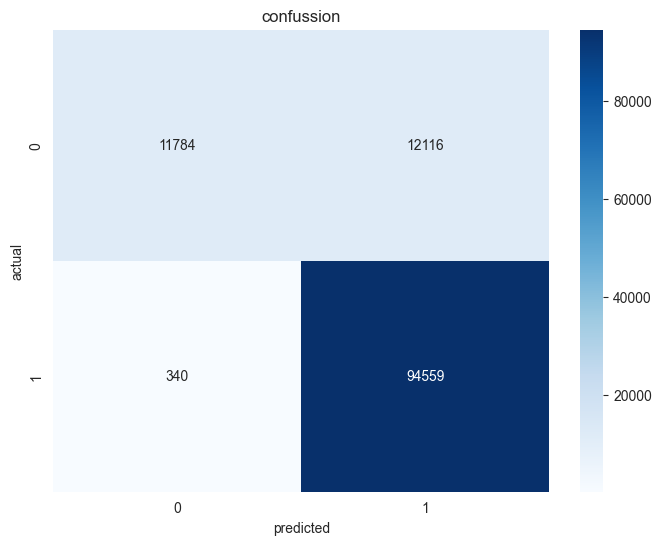

In [168]:
# 计算混淆矩阵
cm = confusion_matrix(valid[TARGET], (valid_fsp_compre > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')

## RESIDUAL MODEL

In [47]:
train_fsp = pd.read_csv(os.path.join(DIR, 'sub\\resample\\train_fsp.csv'), index_col='id')
resid = train[TARGET] - train_fsp[TARGET]

In [48]:
cv = 5
resid_feas_select = []

In [49]:
resid_feas_select.append(('RAW', xgg_feature_test(train[COL], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21527	valid-rmse:0.21064
[200]	train-rmse:0.20531	valid-rmse:0.21328
FOLD 1 RMSE: 0.04549

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21560	valid-rmse:0.20933
[199]	train-rmse:0.20566	valid-rmse:0.21220
FOLD 2 RMSE: 0.04504

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21579	valid-rmse:0.20843
[199]	train-rmse:0.20618	valid-rmse:0.21121
FOLD 3 RMSE: 0.04462

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21522	valid-rmse:0.21080
[200]	train-rmse:0.20521	valid-rmse:0.21397
FOLD 4 RMSE: 0.04579

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20923	valid-rmse:0.23564
[199]	train-rmse:0.19990	valid-rmse:0.23718
FOLD 5 RMSE: 0.05626

MEAN RMSE: 0.04744


In [50]:
resid_feas_select.append(('FREQ', xgg_feature_test(train[COL+FREQ], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21499	valid-rmse:0.21062
[199]	train-rmse:0.20156	valid-rmse:0.21347
FOLD 1 RMSE: 0.04558

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21532	valid-rmse:0.20932
[199]	train-rmse:0.20196	valid-rmse:0.21292
FOLD 2 RMSE: 0.04534

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21554	valid-rmse:0.20844
[200]	train-rmse:0.20224	valid-rmse:0.21113
FOLD 3 RMSE: 0.04458

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21494	valid-rmse:0.21089
[200]	train-rmse:0.20170	valid-rmse:0.21452
FOLD 4 RMSE: 0.04602

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20925	valid-rmse:0.23564
[199]	train-rmse:0.19842	valid-rmse:0.23730
FOLD 5 RMSE: 0.05631

MEAN RMSE: 0.04757


In [51]:
resid_feas_select.append(('ORD', xgg_feature_test(train[COL+ORDCATE], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21527	valid-rmse:0.21064
[199]	train-rmse:0.20533	valid-rmse:0.21328
FOLD 1 RMSE: 0.04549

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21560	valid-rmse:0.20933
[199]	train-rmse:0.20566	valid-rmse:0.21220
FOLD 2 RMSE: 0.04504

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21579	valid-rmse:0.20843
[199]	train-rmse:0.20618	valid-rmse:0.21121
FOLD 3 RMSE: 0.04462

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21522	valid-rmse:0.21080
[199]	train-rmse:0.20523	valid-rmse:0.21395
FOLD 4 RMSE: 0.04578

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20923	valid-rmse:0.23564
[199]	train-rmse:0.19990	valid-rmse:0.23718
FOLD 5 RMSE: 0.05626

MEAN RMSE: 0.04744


In [52]:
resid_feas_select.append(('SUBGRADE', xgg_feature_test(train[COL+SUBGRADE], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21527	valid-rmse:0.21064
[200]	train-rmse:0.20527	valid-rmse:0.21338
FOLD 1 RMSE: 0.04553

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21560	valid-rmse:0.20933
[199]	train-rmse:0.20566	valid-rmse:0.21220
FOLD 2 RMSE: 0.04504

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21579	valid-rmse:0.20843
[200]	train-rmse:0.20614	valid-rmse:0.21123
FOLD 3 RMSE: 0.04462

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21522	valid-rmse:0.21080
[200]	train-rmse:0.20521	valid-rmse:0.21397
FOLD 4 RMSE: 0.04579

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20923	valid-rmse:0.23564
[199]	train-rmse:0.19990	valid-rmse:0.23718
FOLD 5 RMSE: 0.05626

MEAN RMSE: 0.04745


In [53]:
resid_feas_select.append(('TAR', xgg_feature_test(train[COL+TAR], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21276	valid-rmse:0.21047
[200]	train-rmse:0.19441	valid-rmse:0.22908
FOLD 1 RMSE: 0.05248

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21302	valid-rmse:0.21158
[199]	train-rmse:0.19466	valid-rmse:0.23606
FOLD 2 RMSE: 0.05573

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21330	valid-rmse:0.20813
[202]	train-rmse:0.19476	valid-rmse:0.22030
FOLD 3 RMSE: 0.04853

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21276	valid-rmse:0.21044
[202]	train-rmse:0.19371	valid-rmse:0.21372
FOLD 4 RMSE: 0.04567

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20916	valid-rmse:0.23592
[200]	train-rmse:0.19364	valid-rmse:0.24010
FOLD 5 RMSE: 0.05765

MEAN RMSE: 0.05201


In [54]:
resid_feas_select.append(('ROUND', xgg_feature_test(train[COL+ROUND], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.21527	valid-rmse:0.21064
[200]	train-rmse:0.20533	valid-rmse:0.21325
FOLD 1 RMSE: 0.04547

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.21560	valid-rmse:0.20933
[199]	train-rmse:0.20586	valid-rmse:0.21214
FOLD 2 RMSE: 0.04500

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.21579	valid-rmse:0.20843
[200]	train-rmse:0.20615	valid-rmse:0.21112
FOLD 3 RMSE: 0.04457

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.21522	valid-rmse:0.21080
[199]	train-rmse:0.20536	valid-rmse:0.21396
FOLD 4 RMSE: 0.04578

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.20923	valid-rmse:0.23563
[200]	train-rmse:0.20002	valid-rmse:0.23740
FOLD 5 RMSE: 0.05637

MEAN RMSE: 0.04744


In [83]:
resid_feas_select.append(('INTER', xgg_feature_test(train[COL+INTER], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.26365	valid-rmse:0.26427
[200]	train-rmse:0.18506	valid-rmse:0.27084
FOLD 1 RMSE: 0.07335

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.26367	valid-rmse:0.26422
[199]	train-rmse:0.18634	valid-rmse:0.27074
FOLD 2 RMSE: 0.07331

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.26303	valid-rmse:0.26715
[199]	train-rmse:0.18412	valid-rmse:0.27137
FOLD 3 RMSE: 0.07364

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.26339	valid-rmse:0.26536
[200]	train-rmse:0.18409	valid-rmse:0.27781
FOLD 4 RMSE: 0.07718

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.26376	valid-rmse:0.26379
[200]	train-rmse:0.18614	valid-rmse:0.27066
FOLD 5 RMSE: 0.07326

MEAN RMSE: 0.07415


In [55]:
resid_param = tune_xgb_with_optuna(train[COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE], train[TARGET], train_fsp[TARGET], seed=SEED)

[I 2025-11-15 20:21:03,447] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.980773:  10%|█         | 1/10 [03:42<33:23, 222.66s/it, 222.66/900 seconds]

Trial 0: CV AUC = 0.98077
[I 2025-11-15 20:24:46,130] Trial 0 finished with value: 0.9807730326484361 and parameters: {'max_depth': 8, 'min_child_weight': 3.0733603330220305, 'subsample': 0.9727665737993467, 'colsample_bytree': 0.9032150845321725, 'reg_alpha': 1.7948758678099297, 'reg_lambda': 0.9052028417743266, 'gamma': 0.8715852151002684, 'max_leaves': 31}. Best is trial 0 with value: 0.9807730326484361.


Best trial: 1. Best value: 0.980812:  20%|██        | 2/10 [07:09<28:26, 213.33s/it, 429.46/900 seconds]

Trial 1: CV AUC = 0.98081
[I 2025-11-15 20:28:12,923] Trial 1 finished with value: 0.9808119885854335 and parameters: {'max_depth': 6, 'min_child_weight': 11.197661074358638, 'subsample': 0.8876539572796147, 'colsample_bytree': 0.9994142056353793, 'reg_alpha': 1.5186987996807628, 'reg_lambda': 4.972126596308283, 'gamma': 2.9547018368452926, 'max_leaves': 13}. Best is trial 1 with value: 0.9808119885854335.


Best trial: 1. Best value: 0.980812:  30%|███       | 3/10 [10:55<25:34, 219.22s/it, 655.69/900 seconds]

Trial 2: CV AUC = 0.98079
[I 2025-11-15 20:31:59,153] Trial 2 finished with value: 0.9807873822843345 and parameters: {'max_depth': 6, 'min_child_weight': 14.215237387014717, 'subsample': 0.6422033175873808, 'colsample_bytree': 0.6662821788609737, 'reg_alpha': 1.229227284974394, 'reg_lambda': 2.3940724439140366, 'gamma': 0.8476835163543323, 'max_leaves': 22}. Best is trial 1 with value: 0.9808119885854335.


Best trial: 1. Best value: 0.980812:  40%|████      | 4/10 [14:45<22:19, 223.21s/it, 885.01/900 seconds]

Trial 3: CV AUC = 0.98079
[I 2025-11-15 20:35:48,479] Trial 3 finished with value: 0.9807864654057207 and parameters: {'max_depth': 7, 'min_child_weight': 2.6145030544601258, 'subsample': 0.9519490067072297, 'colsample_bytree': 0.6617381452245482, 'reg_alpha': 1.3111819325398162, 'reg_lambda': 1.6308642040854053, 'gamma': 0.5024360852780069, 'max_leaves': 11}. Best is trial 1 with value: 0.9808119885854335.


Best trial: 1. Best value: 0.980812:  50%|█████     | 5/10 [18:11<18:11, 218.35s/it, 1091.76/900 seconds]

Trial 4: CV AUC = 0.98078
[I 2025-11-15 20:39:15,224] Trial 4 finished with value: 0.9807772723254935 and parameters: {'max_depth': 5, 'min_child_weight': 12.664965971401136, 'subsample': 0.9546597028709216, 'colsample_bytree': 0.7821982506099023, 'reg_alpha': 1.8071585494183495, 'reg_lambda': 3.4637251750450866, 'gamma': 3.1544814781227903, 'max_leaves': 24}. Best is trial 1 with value: 0.9808119885854335.

Best trial summary:
  • Best AUC: 0.980812
  • Best parameters: {'max_depth': 6, 'min_child_weight': 11.197661074358638, 'subsample': 0.8876539572796147, 'colsample_bytree': 0.9994142056353793, 'reg_alpha': 1.5186987996807628, 'reg_lambda': 4.972126596308283, 'gamma': 2.9547018368452926, 'max_leaves': 13}


In [56]:
# Save the residual model params
with open(os.path.join(DIR, 'model\\resample\\resid_param.json'), 'w') as f:
    json.dump(resid_param[0], f, indent=4)

In [57]:
# read the base model's predictions
pre_prev_train = pd.read_csv(os.path.join(DIR, 'sub\\resample\\train_fsp.csv'), index_col='id')
pre_prev_valid = pd.read_csv(os.path.join(DIR, 'sub\\resample\\valid_fsp.csv'), index_col='id')
pre_prev_test = pd.read_csv(os.path.join(DIR, 'sub\\resample\\test_fsp.csv'), index_col='id')
resid = train[TARGET] - pre_prev_train[TARGET]

with open(os.path.join(DIR, 'model\\resample\\resid_param.json'), 'r') as f:
    param = json.load(f)
param.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    "learning_rate": 0.005,
    'seed': SEED,
})

cv=5
used_feas = COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_ssp = np.zeros(train.shape[0])
valid_ssp = np.zeros(valid.shape[0])
test_ssp = np.zeros(test.shape[0]) # contain the predictions of test data by base model using cv
auc_res = []
acc_res = []
for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    X_train, X_valid = train[used_feas].iloc[train_idx], train[used_feas].iloc[valid_idx]
    y_train, y_valid = resid.iloc[train_idx], resid.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest = xgb.DMatrix(test[used_feas], enable_categorical=True)
    DVALID = xgb.DMatrix(valid[used_feas], enable_categorical=True)

    # Train base model
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=3000,
        verbose_eval=False,
    )

    # Predict probs
    valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    train_ssp[valid_idx] = valid_preds
    test_ssp += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    valid_ssp += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
    # auc
    valid_preds_proba = np.clip(valid_preds + pre_prev_train.iloc[valid_idx].values.flatten(), 0, 1)
    y_true = train[TARGET].iloc[valid_idx]
    auc = roc_auc_score(y_true, valid_preds_proba)
    auc_res.append(auc)
    # acc
    y_pred = (valid_preds_proba > 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    acc_res.append(acc)
    print(f'{fold+1} auc = {auc:.5f} acc = {acc:.5f}')


test_ssp = test_ssp/cv + pre_prev_test.values.flatten()
valid_ssp = valid_ssp/cv + pre_prev_valid.values.flatten()
# Save test data predictions
pd.DataFrame(data={'id': test.index, TARGET: (test_ssp>0.5).astype(int)}).to_csv(os.path.join(DIR, 'sub\\resample\\test_pred_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': test.index, TARGET: test_ssp}).to_csv(os.path.join(DIR, 'sub\\resample\\test_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': train.index, TARGET: train_ssp}).to_csv(os.path.join(DIR, 'sub\\resample\\train_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid.index, TARGET: valid_ssp}).to_csv(os.path.join(DIR, 'sub\\resample\\valid_ssp.csv'),index=False,header=True)

print(f'BASE MODEL AUC = {np.mean(auc_res):.5f} ACC = {np.mean(acc_res):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[TARGET], valid_ssp)} ACC = {accuracy_score(valid[TARGET], (valid_ssp>0.5).astype(int))}')

1 auc = 0.98088 acc = 0.94236
2 auc = 0.98127 acc = 0.94293
3 auc = 0.98156 acc = 0.94401
4 auc = 0.98100 acc = 0.94246
5 auc = 0.97935 acc = 0.92548
BASE MODEL AUC = 0.98081 ACC = 0.93945.
BASE MODEL ON VALID DATA AUC = 0.980655370459133 ACC = 0.9412269886932423


混淆矩阵:
[[86010  8889]
 [ 2266 92633]]


Text(0.5, 1.0, 'confussion')

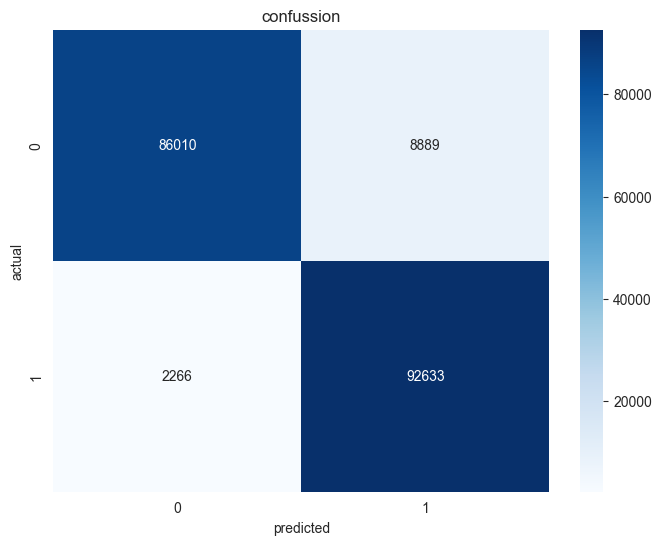

In [58]:
# 计算混淆矩阵
cm = confusion_matrix(valid[TARGET], (valid_ssp > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')